## Базова модель - DenseNet121

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Resizing
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


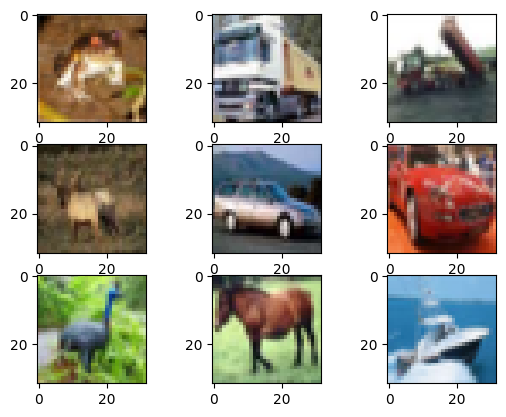

In [2]:
# Завантаження та візуалізація даних CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [3]:
# Аугментація даних
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.3
    )
datagen.fit(x_train)

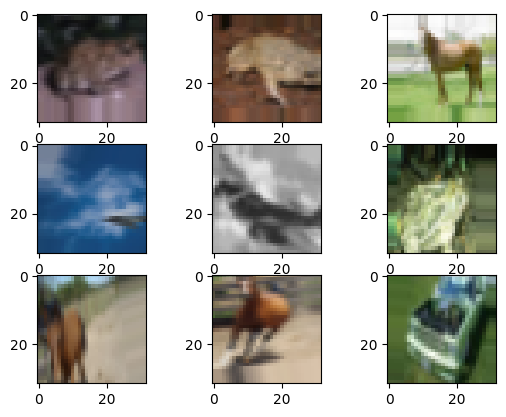

In [4]:
# Попередній показ аугментованих зображень
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [5]:
# Підготовка даних для моделі
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
# Конвертація цілих чисел до float32 і нормалізація з вирівнюванням середнього значення
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [7]:
# Підготовка міток класів
num_classes=10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [8]:
# Створення моделі на основі DenseNet121
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Замороження всіх шарів базової моделі
for layer in base_model.layers:
    layer.trainable = False

# Побудова моделі
model = Sequential([
    Resizing(32, 32, input_shape=(32, 32, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Вибір оптимізатора
opt = Adam(learning_rate=1e-4)

# Компіляція моделі
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Перевірка архітектури моделі
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1, 1, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,727,818 (29.48 MB)

 Trainable params: 690,314 (2.63 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [9]:
# Налаштування чекпоінтів та раннього зупинення
checkpoint = ModelCheckpoint("DenseNet121_cifar10.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001)

In [10]:
# Тренування моделі
history = model.fit(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) // 256,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 365ms/step - accuracy: 0.1247 - loss: 3.1633 - val_accuracy: 0.3985 - val_loss: 2.0335 - learning_rate: 1.0000e-04
Epoch 2/100
  1/195 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.2109 - loss: 2.2113

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2109 - loss: 2.2113 - val_accuracy: 0.3991 - val_loss: 2.0323 - learning_rate: 1.0000e-04
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - accuracy: 0.2111 - loss: 2.1577 - val_accuracy: 0.4654 - val_loss: 1.7288 - learning_rate: 1.0000e-04
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2656 - loss: 2.0285 - val_accuracy: 0.4660 - val_loss: 1.7279 - learning_rate: 1.0000e-04
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 188ms/step - accuracy: 0.2965 - loss: 1.9282 - val_accuracy: 0.4950 - val_loss: 1.5393 - learning_rate: 1.0000e-04
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3477 - loss: 1.8052 - val_accuracy: 0.4953 - val_loss: 1.5385 - learning_rate: 1.0000e-04
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 203ms/step - accuracy: 0.3406 - loss: 1.7964 - val_accuracy: 0.5195 - val_loss: 1.4400 - learning_rate: 1.0000e-04
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - ac

In [11]:
# Функція візуалізації результатів
def plothist(hist):
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

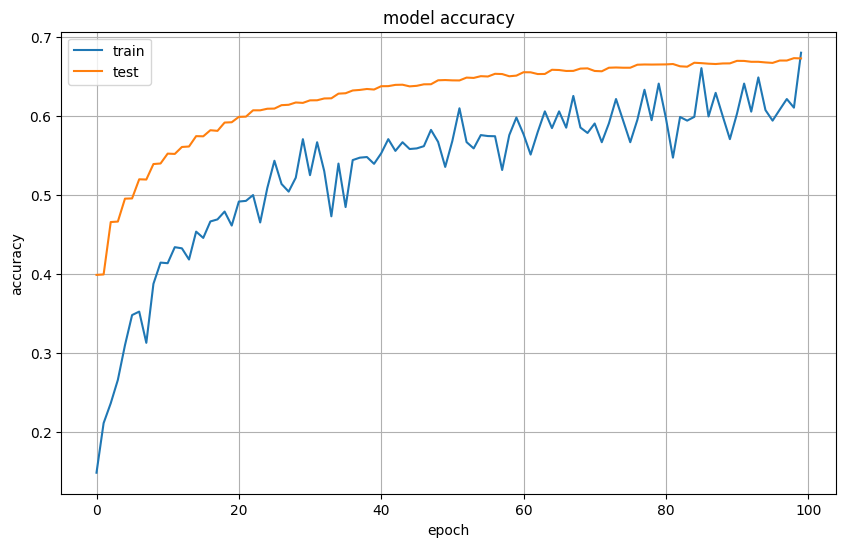

In [12]:
# Візуалізація результатів
plothist(history)

In [13]:
# Оцінка моделі
model_test_acc=model.evaluate(x_test,y_test, batch_size=256)
model_test_acc

model_train_acc=model.evaluate(x_train,y_train, batch_size=256)
model_train_acc

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6771 - loss: 0.9446
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6959 - loss: 0.8972


[0.8971269726753235, 0.6935200095176697]

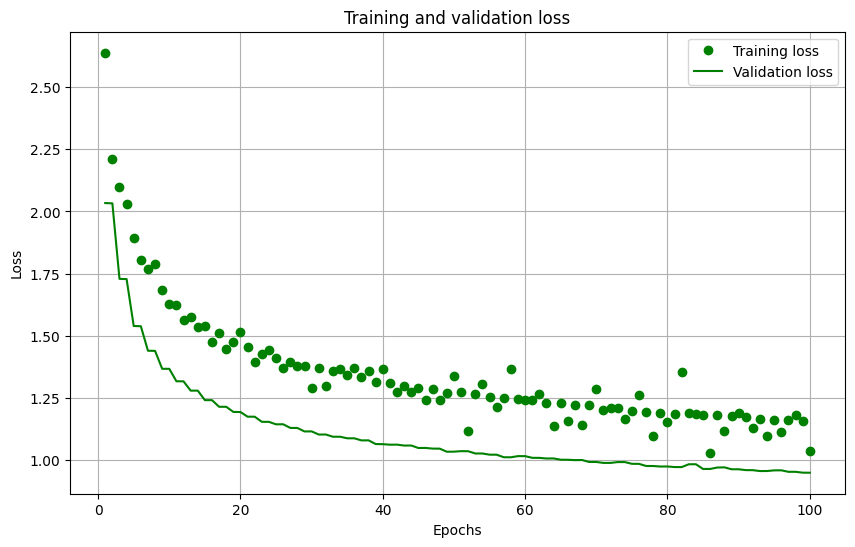

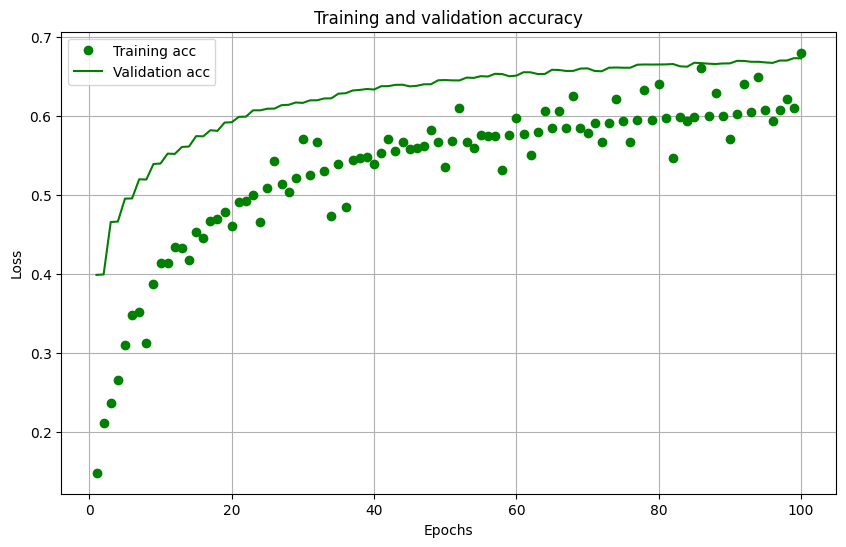

In [14]:
# Візуалізація втрат та точності
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(epochs, loss_values, 'go', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_dict['accuracy'], 'go', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Донавчання моделі

In [17]:
# Розмороження останніх декількох шарів DenseNet121
fine_tune_at = 200

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


# Компіляція моделі з нижчим learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Перевірка архітектури моделі
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1, 1, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,727,818 (29.48 MB)

 Trainable params: 690,314 (2.63 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [18]:
# Повторне тренування та візуалізація результатів після донавчання
history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) // 256,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 333ms/step - accuracy: 0.6076 - loss: 1.1573 - val_accuracy: 0.6710 - val_loss: 0.9485 - learning_rate: 1.0000e-05
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6875 - loss: 1.0837 - val_accuracy: 0.6709 - val_loss: 0.9485 - learning_rate: 1.0000e-05
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - accuracy: 0.6067 - loss: 1.1581 - val_accuracy: 0.6714 - val_loss: 0.9484 - learning_rate: 1.0000e-05
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6289 - loss: 1.1512 - val_accuracy: 0.6715 - val_loss: 0.9484 - learning_rate: 1.0000e-05
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 192ms/step - accuracy: 0.6124 - loss: 1.1444 - val_accuracy: 0.6725 - val_loss: 0.9469 - learning_rate: 1.0000e-05
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6094 - loss: 1.2682 - val_accuracy: 0.6724 - val_loss: 0.9469 - learning_rate: 1.0000e-05
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 1

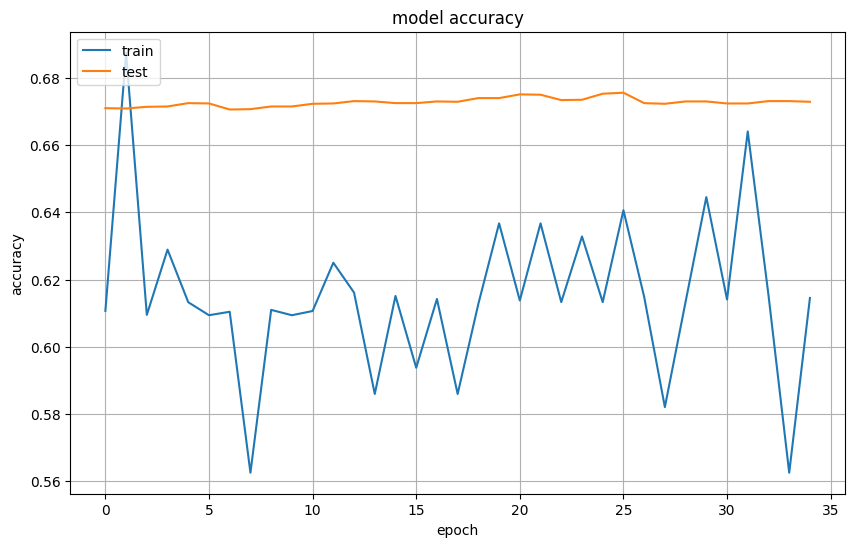

In [19]:
# Візуалізація результатів
plothist(history_fine)

In [20]:
# Оцінка моделі після донавчання
model_test_acc=model.evaluate(x_test,y_test, batch_size=256)
model_test_acc

model_train_acc=model.evaluate(x_train,y_train, batch_size=256)
model_train_acc

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6796 - loss: 0.9362
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6975 - loss: 0.8836


[0.8837942481040955, 0.6966000199317932]

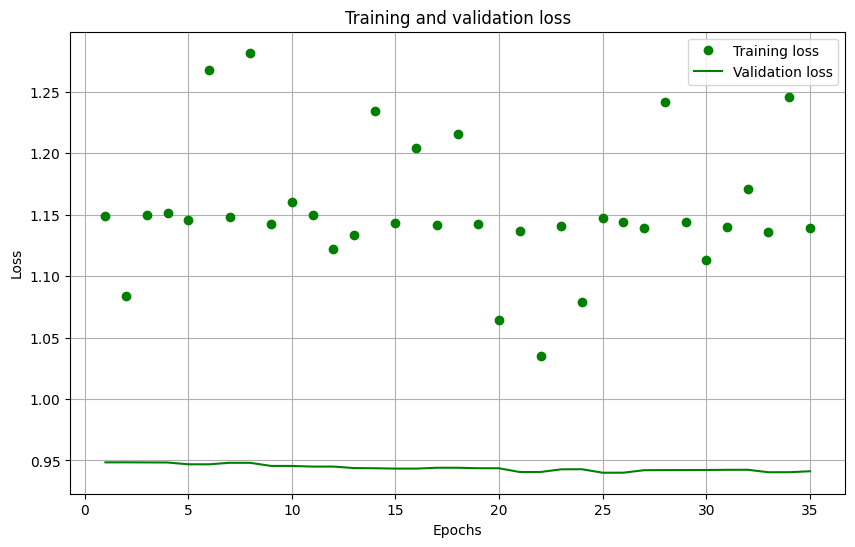

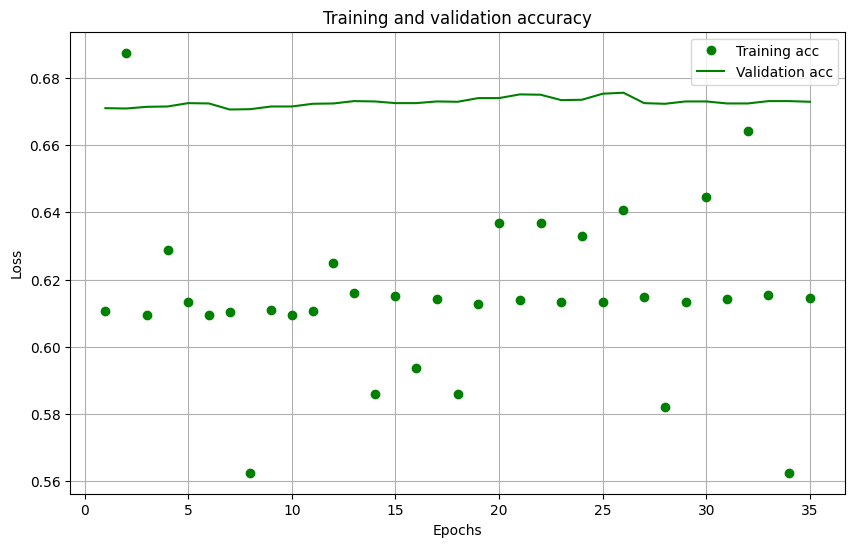

In [21]:
# Повторна візуалізація втрат та точності після донавчання
history_fine_dict = history_fine.history
loss_values = history_fine_dict['loss']
val_loss_values = history_fine_dict['val_loss']

epochs = range(1, len(history_fine_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(epochs, loss_values, 'go', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_fine_dict['accuracy'], 'go', label='Training acc')
plt.plot(epochs, history_fine_dict['val_accuracy'], 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#Збереження моделі і перевірка роботи

In [22]:
model.save("DenseNet121_cifar10.keras")

In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [24]:
!ls /content

DenseNet121_cifar10.keras  drive  sample_data


In [25]:
!ls '/content/drive/MyDrive/NeuroContact/'

DenseNet121_cifar10_last_17.08.2024.keras  model_notebooks  predict_images


In [27]:
# Переміщення файлу на Google Drive
!cp /content/DenseNet121_cifar10.keras /content/drive/MyDrive/NeuroContact/

In [ ]:
# Завантаження моделі
model_path = '/content/drive/MyDrive/NeuroContact/DenseNet121_cifar10.keras'
model = tf.keras.models.load_model(model_path)

In [ ]:
# Завантаження зображення з Google Диску
img_path = '/content/drive/MyDrive/NeuroContact/predict_images/ship.jpg'

# Завантаження зображення
img = Image.open(img_path)

# Підготовка зображення
img = img.resize((32, 32))  # зміна розміру зображення до розмірів CIFAR-10
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0  # нормалізація зображення

# Передбачення
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Класи CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Виведення результату
print(f"Predicted class: {class_names[predicted_class]}")
plt.imshow(img)
plt.title(f"Predicted class: {class_names[predicted_class]}")
plt.show()